In [2]:
import sys
sys.path.append("/home/psireal42/study/ml-project")

In [3]:
# model
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric as tg
import torch_scatter
import e3nn
from e3nn import o3
from typing import Dict, Union

# crystal structure data
from ase import Atom, Atoms
from ase.neighborlist import neighbor_list
from ase.visualize.plot import plot_atoms

# data pre-processing and visualization
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# utilities
import time
from tqdm import tqdm, trange
from src.data import (load_data, train_valid_test_split, plot_example, plot_predictions, plot_partials,
                              palette, colors, cmap)
from src.model import Network, visualize_layers, train
from src.plot import plotly_surface, plot_orbitals, get_middle_feats

bar_format = '{l_bar}{bar:10}{r_bar}{bar:-10b}'
default_dtype = torch.float64
torch.set_default_dtype(default_dtype)

In [4]:
# automatic reloading of modules before executing code
%load_ext autoreload
%autoreload 2 

In [5]:
# load data
data, species = load_data('data/data.csv')
len(data)

100%|██████████| 1522/1522 [00:00<00:00, 69079.02it/s]


1522

In [6]:
# filter structures with 2 elements
two_elements = data.species.apply(lambda x: len(x) == 2)
two_elements = data[two_elements]
two_elements_species = sorted(list(set(two_elements.species.sum())))
two_elements.index = np.arange(len(two_elements))
len(two_elements)

363

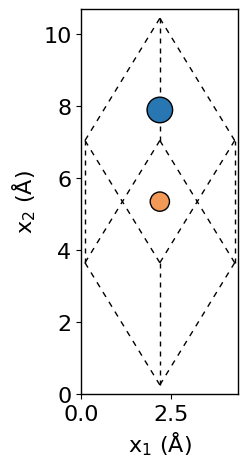

In [65]:
# plot an example structure
i = 113 # structure index 

struct = two_elements.iloc[i]['structure']
symbols = np.unique(list(struct.symbols))
z = dict(zip(symbols, range(len(symbols))))

fig, ax = plt.subplots(figsize=(6,5))
norm = plt.Normalize(vmin=0, vmax=len(symbols)-1)
color = [mpl.colors.to_hex(k) for k in cmap(norm([z[j] for j in list(struct.symbols)]))]
plot_atoms(struct, ax, radii=0.25, colors=color, rotation=('0x,90y,0z'))

ax.set_xlabel(r'$x_1\ (\AA)$')
ax.set_ylabel(r'$x_2\ (\AA)$');

average lattice parameter (a/b/c): 4.392439414117347 / 4.816188714594655 / 5.711118856662181


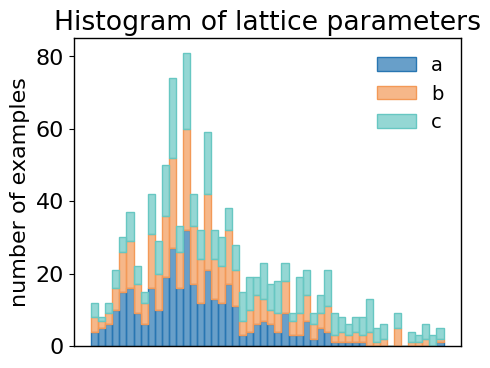

In [7]:
# lattice parameter statistics
def get_lattice_parameters(data):
    a = []
    for entry in data.itertuples():
        a.append(entry.structure.cell.cellpar()[:3])
    return np.stack(a)

lattice_params = get_lattice_parameters(two_elements)

fig, ax = plt.subplots(1,1, figsize=(5,4))
b = 0.
bins = 50

for d, c, n in zip(['a', 'b', 'c'], colors.values(), [lattice_params[:,0], lattice_params[:,1], lattice_params[:,2]]):
    color = [int(c.lstrip('#')[i:i+2], 16)/255. for i in (0,2,4)]
    y, bins, _, = ax.hist(n, bins=bins, fc=color+[0.7], ec=color, bottom=b, label=d)
    b += y

ax.set_xticks([])
ax.set_ylabel("number of examples")
ax.set_title("Histogram of lattice parameters")
ax.legend(frameon=False)

print("average lattice parameter (a/b/c):", lattice_params[:,0].mean(), "/", lattice_params[:,1].mean(), "/", lattice_params[:,2].mean())

In [8]:
# create one-hot encoding for atom types
type_encoding = {}
specie_am = []
for Z in trange(1,119):
    specie = Atom(Z)
    type_encoding[specie.symbol] = Z - 1
    specie_am.append(specie.mass)

type_onehot = torch.eye(len(type_encoding))
am_onehot = torch.diag(torch.tensor(specie_am))
type_onehot.size(), am_onehot.size()

100%|██████████| 118/118 [00:00<00:00, 269275.23it/s]


(torch.Size([118, 118]), torch.Size([118, 118]))

In [9]:
# build data
def build_data(entry, type_encoding, type_onehot, r_max=5.):
    symbols = list(entry.structure.symbols).copy()
    positions = torch.from_numpy(entry.structure.positions.copy())
    lattice = torch.from_numpy(entry.structure.cell.array.copy()).unsqueeze(0)

    # edge_src and edge_dst are the indices of the central and neighboring atom, respectively
    # edge_shift indicates whether the neighbors are in different images or copies of the unit cell
    edge_src, edge_dst, edge_shift = neighbor_list("ijS", a=entry.structure, cutoff=r_max, self_interaction=True)
    
    # compute the relative distances and unit cell shifts from periodic boundaries
    edge_batch = positions.new_zeros(positions.shape[0], dtype=torch.long)[torch.from_numpy(edge_src)]
    edge_vec = (positions[torch.from_numpy(edge_dst)]
                - positions[torch.from_numpy(edge_src)]
                + torch.einsum('ni,nij->nj', torch.tensor(edge_shift, dtype=default_dtype), lattice[edge_batch]))

    # compute edge lengths (rounded only for plotting purposes)
    edge_len = np.around(edge_vec.norm(dim=1).numpy(), decimals=2)
    
    two_elements = tg.data.Data(
        pos=positions, lattice=lattice, symbol=symbols,
        x=am_onehot[[type_encoding[specie] for specie in symbols]],   # atomic mass (node feature)
        z=type_onehot[[type_encoding[specie] for specie in symbols]], # atom type (node attribute)
        edge_index=torch.stack([torch.LongTensor(edge_src), torch.LongTensor(edge_dst)], dim=0),
        edge_shift=torch.tensor(edge_shift, dtype=default_dtype),
        edge_vec=edge_vec, edge_len=edge_len,
        phdos=torch.from_numpy(entry.phdos).unsqueeze(0)
    )
    
    return two_elements

r_max = 4. # cutoff radius
two_elements['data'] = two_elements.progress_apply(lambda x: build_data(x, type_encoding, type_onehot, r_max), axis=1)

100%|██████████| 363/363 [00:08<00:00, 45.21it/s]
/tmp/ipykernel_259813/1214290054.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  two_elements['data'] = two_elements.progress_apply(lambda x: build_data(x, type_encoding, type_onehot, r_max), axis=1)


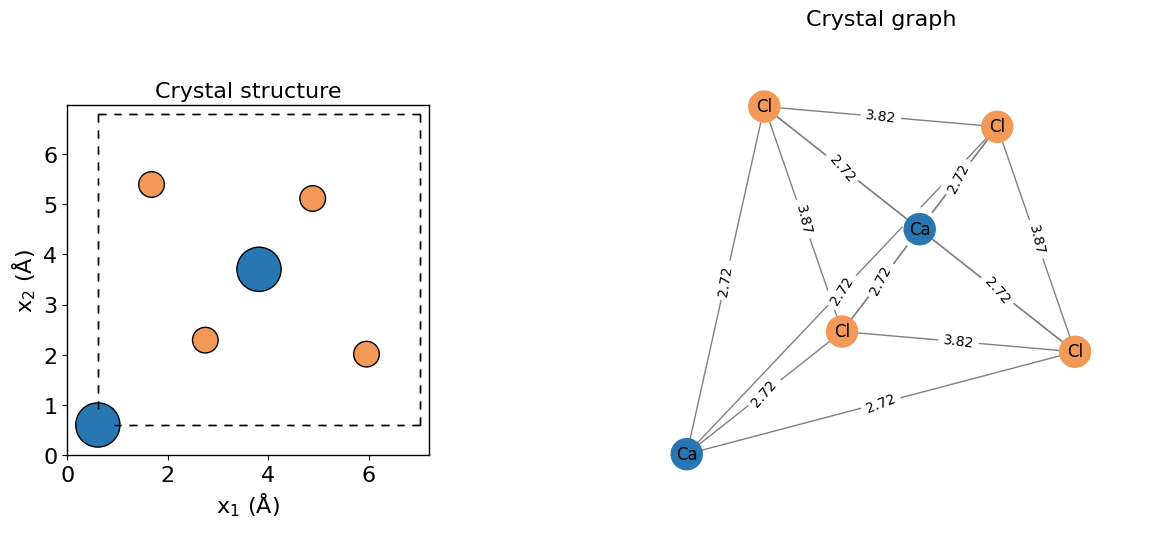

In [94]:
i = 160 # structure index in dataframe
plot_example(two_elements, i=i, label_edges=True)

split train/dev ...


100%|██████████| 58/58 [00:00<00:00, 495.48it/s]


split valid/test ...


100%|██████████| 55/55 [00:00<00:00, 650.74it/s]


number of training examples: 273
number of validation examples: 42
number of testing examples: 48
total number of examples: 363


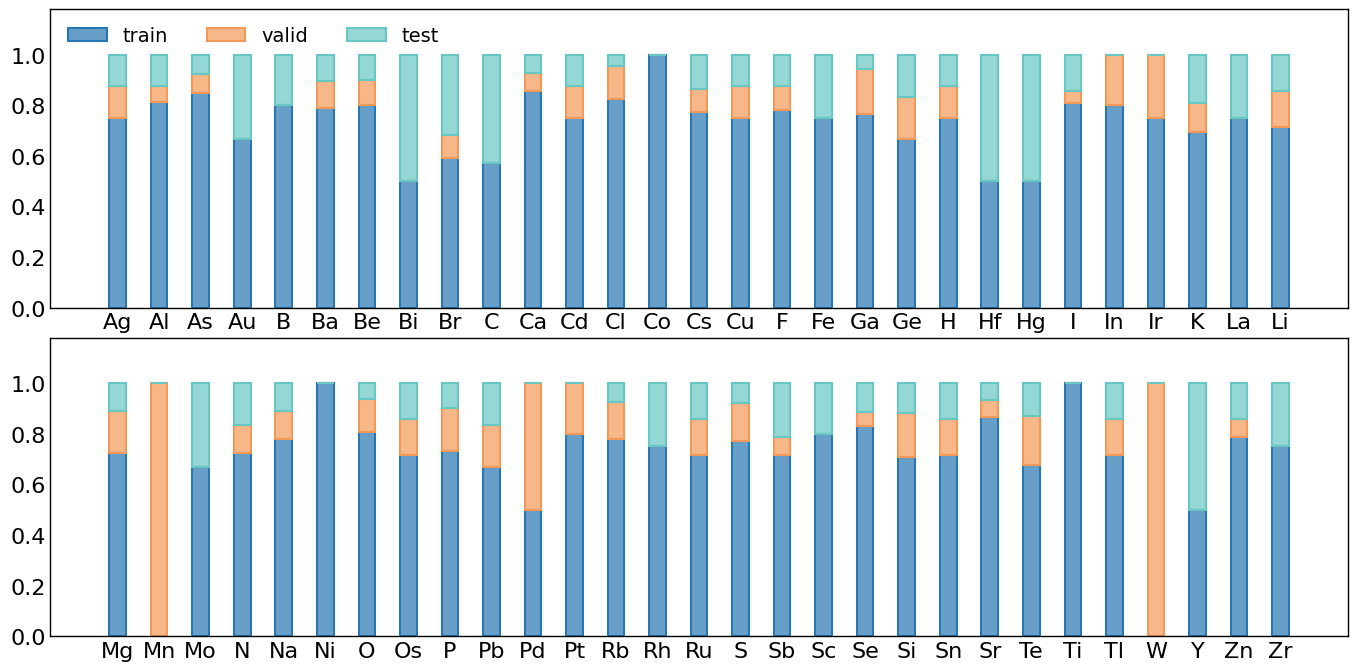

In [36]:
# train/valid/test split
idx_train, idx_valid, idx_test = train_valid_test_split(two_elements, two_elements_species, valid_size=.1, test_size=.1, seed=12, plot=True)

In [11]:
# format dataloaders
batch_size = 1
dataloader_train = tg.loader.DataLoader(two_elements.iloc[idx_train]['data'].values, batch_size=batch_size, shuffle=True)
dataloader_valid = tg.loader.DataLoader(two_elements.iloc[idx_valid]['data'].values, batch_size=batch_size)
dataloader_test = tg.loader.DataLoader(two_elements.iloc[idx_test]['data'].values, batch_size=batch_size)

average number of neighbors (train/valid/test): 15.210378681626928 / 15.139705882352942 / 15.801652892561984


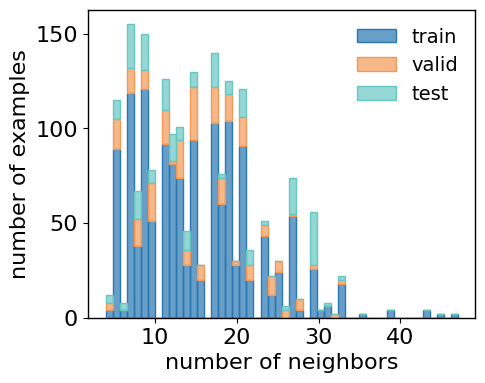

In [12]:
# calculate average number of neighbors
def get_neighbors(df, idx):
    n = []
    for entry in df.iloc[idx].itertuples():
        N = entry.data.pos.shape[0]
        for i in range(N):
            n.append(len((entry.data.edge_index[0] == i).nonzero()))
    return np.array(n)

n_train = get_neighbors(two_elements, idx_train)
n_valid = get_neighbors(two_elements, idx_valid)
n_test = get_neighbors(two_elements, idx_test)

fig, ax = plt.subplots(1,1, figsize=(5,4))
b = 0.
bins = 50
for (d, c), n in zip(colors.items(), [n_train, n_valid, n_test]):
    color = [int(c.lstrip('#')[i:i+2], 16)/255. for i in (0,2,4)]
    y, bins, _, = ax.hist(n, bins=bins, fc=color+[0.7], ec=color, bottom=b, label=d)
    b += y
ax.set_xlabel('number of neighbors')
ax.set_ylabel('number of examples')
ax.legend(frameon=False)

print('average number of neighbors (train/valid/test):', n_train.mean(), '/', n_valid.mean(), '/', n_test.mean())

In [14]:
class PeriodicNetwork(Network):
    def __init__(self, in_dim, em_dim, **kwargs):            
        # override the `reduce_output` keyword to instead perform an averge over atom contributions    
        self.pool = False
        if kwargs['reduce_output'] == True:
            kwargs['reduce_output'] = False
            self.pool = True
            
        super().__init__(**kwargs)

        # embed the mass-weighted one-hot encoding
        self.em = nn.Linear(in_dim, em_dim)

    def forward(self, data: Union[tg.data.Data, Dict[str, torch.Tensor]]) -> torch.Tensor:
        data.x = F.relu(self.em(data.x))
        data.z = F.relu(self.em(data.z))
        output = super().forward(data)
        output = torch.relu(output)
        
        # if pool_nodes was set to True, use scatter_mean to aggregate
        if self.pool == True:
            output = torch_scatter.scatter_mean(output, data.batch, dim=0)  # take mean over atoms per example
        
        maxima, _ = torch.max(output, dim=1)
        output = output.div(maxima.unsqueeze(1))
        
        return output

In [15]:
out_dim = len(two_elements.iloc[0]['phfreq'])
em_dim = 64  

model = PeriodicNetwork(
    in_dim=118,                            # dimension of one-hot encoding of atom type
    em_dim=em_dim,                         # dimension of atom-type embedding
    irreps_in=str(em_dim)+"x0e",           # em_dim scalars (L=0 and even parity) on each atom to represent atom type
    irreps_out=str(out_dim)+"x0e",         # out_dim scalars (L=0 and even parity) to output
    irreps_node_attr=str(em_dim)+"x0e",    # em_dim scalars (L=0 and even parity) on each atom to represent atom type
    layers=2,                              # number of nonlinearities (number of convolutions = layers + 1)
    mul=32,                                # multiplicity of irreducible representations
    lmax=1,                                # maximum order of spherical harmonics
    max_radius=r_max,                      # cutoff radius for convolution
    num_neighbors=n_train.mean(),          # scaling factor based on the typical number of neighbors
    reduce_output=True                     # whether or not to aggregate features of all atoms at the end
)

print(model)

/home/psireal42/miniconda3/envs/ml-project/lib/python3.10/site-packages/torch/jit/_check.py:172: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn("The TorchScript type system doesn't support "


PeriodicNetwork(
  (layers): ModuleList(
    (0): CustomCompose(
      (first): Convolution(
        (sc): FullyConnectedTensorProduct(64x0e x 64x0e -> 64x0e+32x1o | 262144 paths | 262144 weights)
        (lin1): FullyConnectedTensorProduct(64x0e x 64x0e -> 64x0e | 262144 paths | 262144 weights)
        (fc): FullyConnectedNet[10, 100, 128]
        (tp): TensorProduct(64x0e x 1x0e+1x1o -> 64x0e+64x1o | 128 paths | 128 weights)
        (lin2): FullyConnectedTensorProduct(64x0e+64x1o x 64x0e -> 64x0e+32x1o | 393216 paths | 393216 weights)
      )
      (second): Gate (64x0e+32x1o -> 32x0e+32x1o)
    )
    (1): CustomCompose(
      (first): Convolution(
        (sc): FullyConnectedTensorProduct(32x0e+32x1o x 64x0e -> 96x0e+32x1o+32x1e | 262144 paths | 262144 weights)
        (lin1): FullyConnectedTensorProduct(32x0e+32x1o x 64x0e -> 32x0e+32x1o | 131072 paths | 131072 weights)
        (fc): FullyConnectedNet[10, 100, 160]
        (tp): TensorProduct(32x0e+32x1o x 1x0e+1x1o -> 64x0e+64x1o+

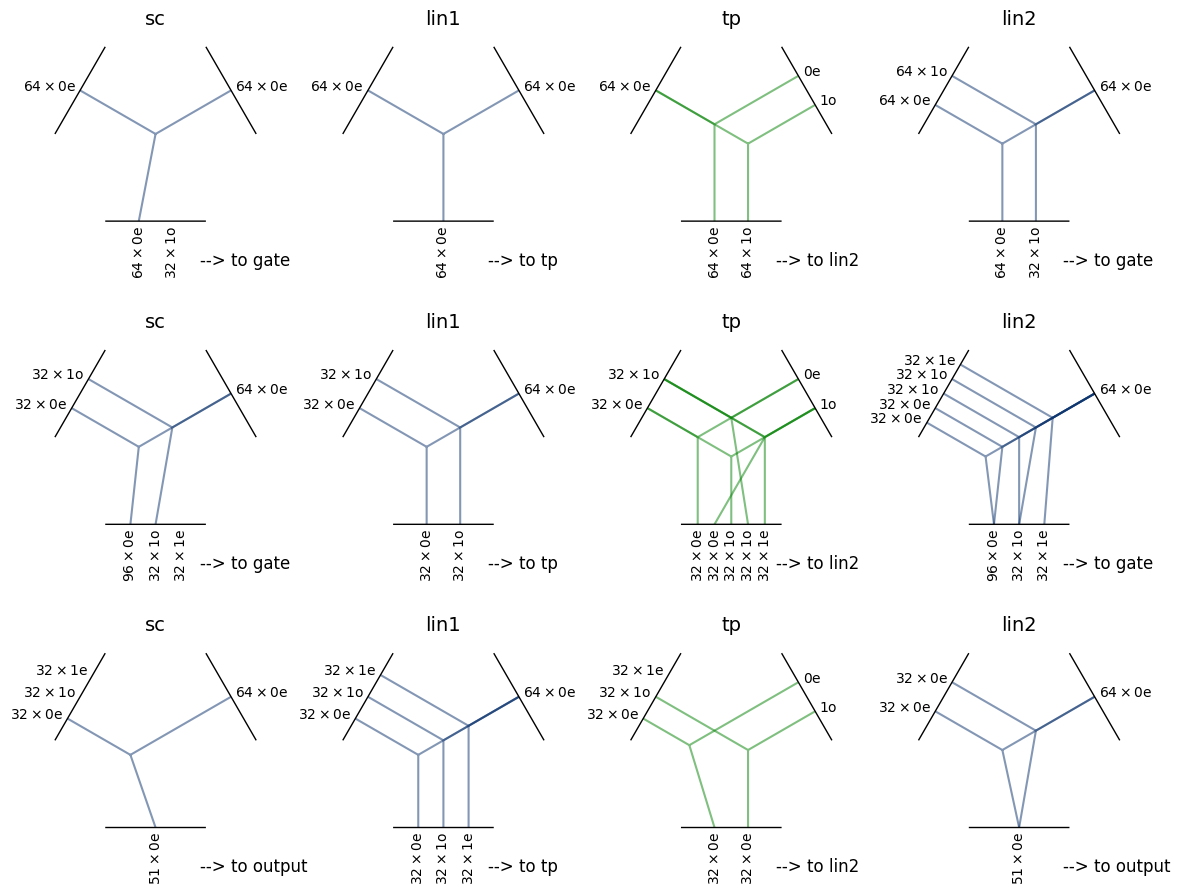

In [17]:
# visualize tensor products of the model
visualize_layers(model)

In [18]:
# training
opt = torch.optim.AdamW(model.parameters(), lr=0.005, weight_decay=0.05)
scheduler = torch.optim.lr_scheduler.ExponentialLR(opt, gamma=0.96)

loss_fn = torch.nn.MSELoss()
loss_fn_mae = torch.nn.L1Loss()

In [19]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print('torch device:' , device)

run_name = "model_" + "two_elements"

torch device: cpu


In [20]:
model.pool = True
train(model, opt, dataloader_train, dataloader_valid, loss_fn, loss_fn_mae, run_name,
      max_iter=60, scheduler=scheduler, device=device)

100%|██████████| 273/273 [00:10<00:00, 24.94it/s]


Iteration    1   train loss =   0.0385   valid loss =   0.0442   elapsed time = 00:00:10


100%|██████████| 273/273 [00:09<00:00, 27.52it/s]


Iteration    2   train loss =   0.0331   valid loss =   0.0432   elapsed time = 00:00:24


100%|██████████| 273/273 [00:11<00:00, 24.42it/s]


Iteration    3   train loss =   0.0251   valid loss =   0.0367   elapsed time = 00:00:38


100%|██████████| 273/273 [00:11<00:00, 23.20it/s]


Iteration    4   train loss =   0.0232   valid loss =   0.0383   elapsed time = 00:00:53


100%|██████████| 273/273 [00:10<00:00, 25.98it/s]


Iteration    5   train loss =   0.0198   valid loss =   0.0342   elapsed time = 00:01:06


100%|██████████| 273/273 [00:10<00:00, 26.66it/s]


Iteration    7   train loss =   0.0146   valid loss =   0.0319   elapsed time = 00:01:29


100%|██████████| 273/273 [00:09<00:00, 29.08it/s]


Iteration    9   train loss =   0.0119   valid loss =   0.0297   elapsed time = 00:01:52


100%|██████████| 273/273 [00:11<00:00, 24.02it/s]


Iteration   11   train loss =   0.0095   valid loss =   0.0278   elapsed time = 00:02:18


100%|██████████| 273/273 [00:09<00:00, 29.31it/s]


Iteration   14   train loss =   0.0080   valid loss =   0.0269   elapsed time = 00:02:51


100%|██████████| 273/273 [00:10<00:00, 26.89it/s]


Iteration   17   train loss =   0.0059   valid loss =   0.0260   elapsed time = 00:03:27


100%|██████████| 273/273 [00:10<00:00, 25.87it/s]


Iteration   21   train loss =   0.0053   valid loss =   0.0266   elapsed time = 00:04:10


100%|██████████| 273/273 [00:10<00:00, 24.97it/s]


Iteration   25   train loss =   0.0040   valid loss =   0.0261   elapsed time = 00:04:55


100%|██████████| 273/273 [00:11<00:00, 22.77it/s]


Iteration   29   train loss =   0.0032   valid loss =   0.0245   elapsed time = 00:05:39


100%|██████████| 273/273 [00:10<00:00, 25.42it/s]


Iteration   34   train loss =   0.0024   valid loss =   0.0248   elapsed time = 00:06:36


100%|██████████| 273/273 [00:10<00:00, 25.07it/s]


Iteration   39   train loss =   0.0021   valid loss =   0.0243   elapsed time = 00:07:29


100%|██████████| 273/273 [00:09<00:00, 27.42it/s]


Iteration   44   train loss =   0.0017   valid loss =   0.0256   elapsed time = 00:08:23


100%|██████████| 273/273 [00:09<00:00, 28.85it/s]


Iteration   49   train loss =   0.0014   valid loss =   0.0249   elapsed time = 00:09:12


100%|██████████| 273/273 [00:10<00:00, 24.93it/s]


Iteration   54   train loss =   0.0011   valid loss =   0.0251   elapsed time = 00:10:06


100%|██████████| 273/273 [00:08<00:00, 30.35it/s]


Iteration   59   train loss =   0.0010   valid loss =   0.0250   elapsed time = 00:10:59


100%|██████████| 273/273 [00:09<00:00, 29.29it/s]


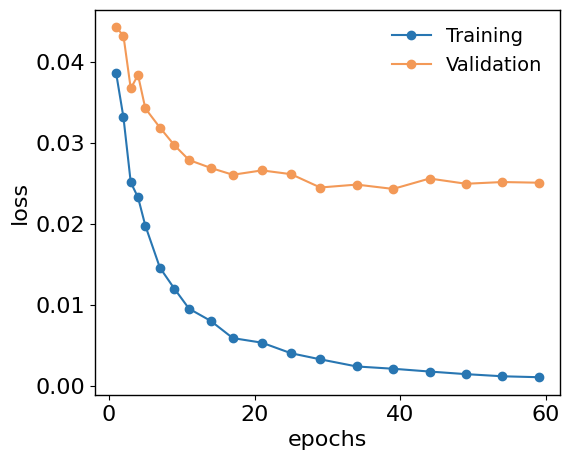

In [21]:
# load pre-trained model and plot its training history

history = torch.load(run_name + '.torch', map_location=device)['history']
steps = [d['step'] + 1 for d in history]
loss_train = [d['train']['loss'] for d in history]
loss_valid = [d['valid']['loss'] for d in history]

fig, ax = plt.subplots(figsize=(6,5))
ax.plot(steps, loss_train, 'o-', label="Training", color=colors['train'])
ax.plot(steps, loss_valid, 'o-', label="Validation", color=colors['valid'])
ax.set_xlabel('epochs')
ax.set_ylabel('loss')
ax.legend(frameon=False);

## Predict on 2-element data

In [22]:
model.load_state_dict(torch.load(run_name + '.torch', map_location=device)['state'])
model.pool = True

dataloader = tg.loader.DataLoader(two_elements['data'].values, batch_size=64)
two_elements['mse'] = 0.
two_elements['phdos_pred'] = np.empty((len(two_elements), 0)).tolist()

model.to(device)
model.eval()
with torch.no_grad():
    i0 = 0
    for i, d in tqdm(enumerate(dataloader), total=len(dataloader), bar_format=bar_format):
        d.to(device)
        output = model(d)
        loss = F.mse_loss(output, d.phdos, reduction='none').mean(dim=-1).cpu().numpy()
        two_elements.loc[i0:i0 + len(d.phdos) - 1, 'phdos_pred'] = [[k] for k in output.cpu().numpy()]
        two_elements.loc[i0:i0 + len(d.phdos) - 1, 'mse'] = loss
        i0 += len(d.phdos)
        
two_elements['phdos_pred'] = two_elements['phdos_pred'].map(lambda x: x[0])

/tmp/ipykernel_259813/3585524819.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  two_elements['mse'] = 0.
/tmp/ipykernel_259813/3585524819.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  two_elements['phdos_pred'] = np.empty((len(two_elements), 0)).tolist()
100%|██████████| 6/6 [00:00<00:00, 16.24it/s]
/tmp/ipykernel_259813/3585524819.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

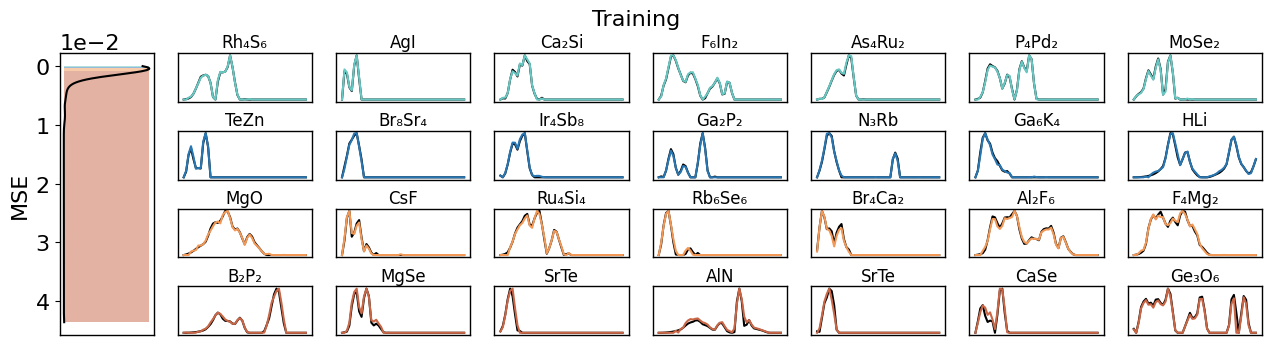

In [24]:
plot_predictions(two_elements, idx_train, 'Training')

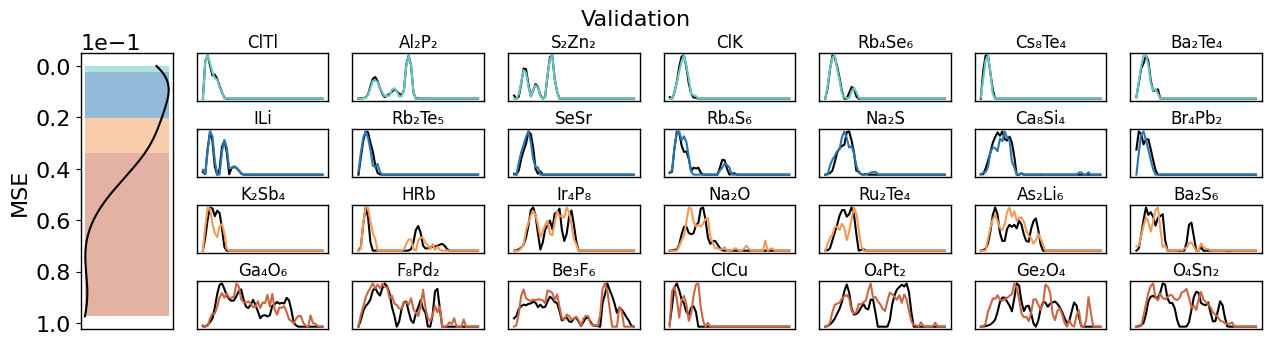

In [25]:
plot_predictions(two_elements, idx_valid, 'Validation')

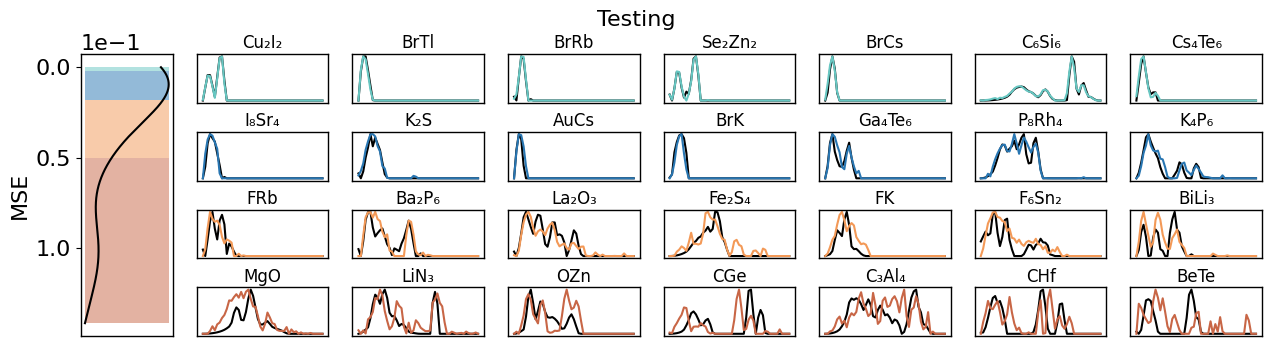

In [26]:
plot_predictions(two_elements, idx_test, 'Testing')

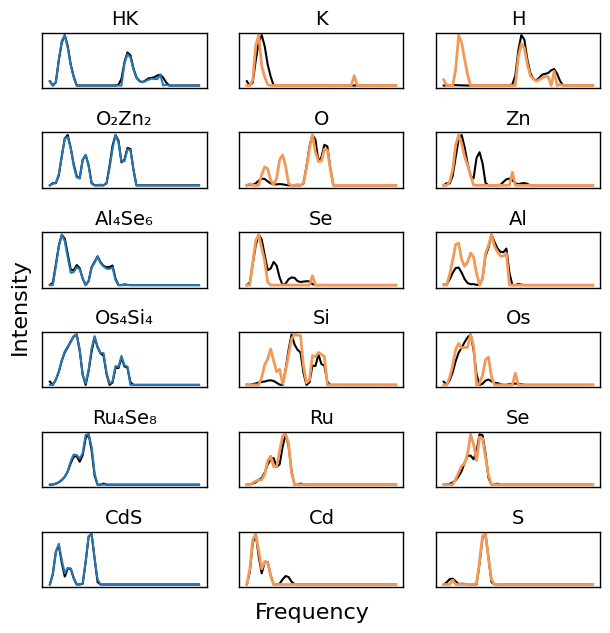

In [37]:
# compare to partial DoS
model.load_state_dict(torch.load(run_name + '.torch', map_location=device)['state'])
model.pool = False

# plot example predicted and true partial dos
plot_partials(model, two_elements, idx_train, device=device)

## Predict on all data

In [29]:
# build data
def build_data(entry, type_encoding, type_onehot, r_max=5.):
    symbols = list(entry.structure.symbols).copy()
    positions = torch.from_numpy(entry.structure.positions.copy())
    lattice = torch.from_numpy(entry.structure.cell.array.copy()).unsqueeze(0)

    # edge_src and edge_dst are the indices of the central and neighboring atom, respectively
    # edge_shift indicates whether the neighbors are in different images or copies of the unit cell
    edge_src, edge_dst, edge_shift = neighbor_list("ijS", a=entry.structure, cutoff=r_max, self_interaction=True)
    
    # compute the relative distances and unit cell shifts from periodic boundaries
    edge_batch = positions.new_zeros(positions.shape[0], dtype=torch.long)[torch.from_numpy(edge_src)]
    edge_vec = (positions[torch.from_numpy(edge_dst)]
                - positions[torch.from_numpy(edge_src)]
                + torch.einsum('ni,nij->nj', torch.tensor(edge_shift, dtype=default_dtype), lattice[edge_batch]))

    # compute edge lengths (rounded only for plotting purposes)
    edge_len = np.around(edge_vec.norm(dim=1).numpy(), decimals=2)
    
    data = tg.data.Data(
        pos=positions, lattice=lattice, symbol=symbols,
        x=am_onehot[[type_encoding[specie] for specie in symbols]],   # atomic mass (node feature)
        z=type_onehot[[type_encoding[specie] for specie in symbols]], # atom type (node attribute)
        edge_index=torch.stack([torch.LongTensor(edge_src), torch.LongTensor(edge_dst)], dim=0),
        edge_shift=torch.tensor(edge_shift, dtype=default_dtype),
        edge_vec=edge_vec, edge_len=edge_len,
        phdos=torch.from_numpy(entry.phdos).unsqueeze(0)
    )
    
    return data

r_max = 4. # cutoff radius
data['data'] = data.progress_apply(lambda x: build_data(x, type_encoding, type_onehot, r_max), axis=1)

  0%|          | 0/1522 [00:00<?, ?it/s]

100%|██████████| 1522/1522 [00:38<00:00, 39.16it/s]


In [30]:
# predict on all data
model.load_state_dict(torch.load(run_name + '.torch', map_location=device)['state'])
model.pool = True

dataloader = tg.loader.DataLoader(data['data'].values, batch_size=64)
data['mse'] = 0.
data['phdos_pred'] = np.empty((len(data), 0)).tolist()

model.to(device)
model.eval()
with torch.no_grad():
    i0 = 0
    for i, d in tqdm(enumerate(dataloader), total=len(dataloader), bar_format=bar_format):
        d.to(device)
        output = model(d)
        loss = F.mse_loss(output, d.phdos, reduction='none').mean(dim=-1).cpu().numpy()
        data.loc[i0:i0 + len(d.phdos) - 1, 'phdos_pred'] = [[k] for k in output.cpu().numpy()]
        data.loc[i0:i0 + len(d.phdos) - 1, 'mse'] = loss
        i0 += len(d.phdos)
        
data['phdos_pred'] = data['phdos_pred'].map(lambda x: x[0])

  0%|          | 0/24 [00:00<?, ?it/s]

100%|██████████| 24/24 [00:01<00:00, 12.86it/s]


In [38]:
# load train/valid/test indices
with open('data/idx_train.txt', 'r') as f: idx_train = [int(i.split('\n')[0]) for i in f.readlines()]
with open('data/idx_valid.txt', 'r') as f: idx_valid = [int(i.split('\n')[0]) for i in f.readlines()]
with open('data/idx_test.txt', 'r') as f: idx_test = [int(i.split('\n')[0]) for i in f.readlines()]

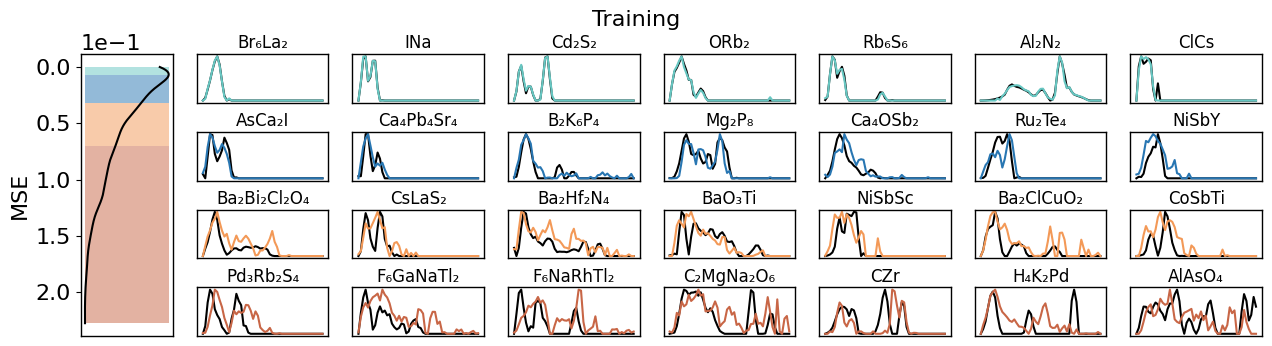

In [32]:
plot_predictions(data, idx_train, 'Training')

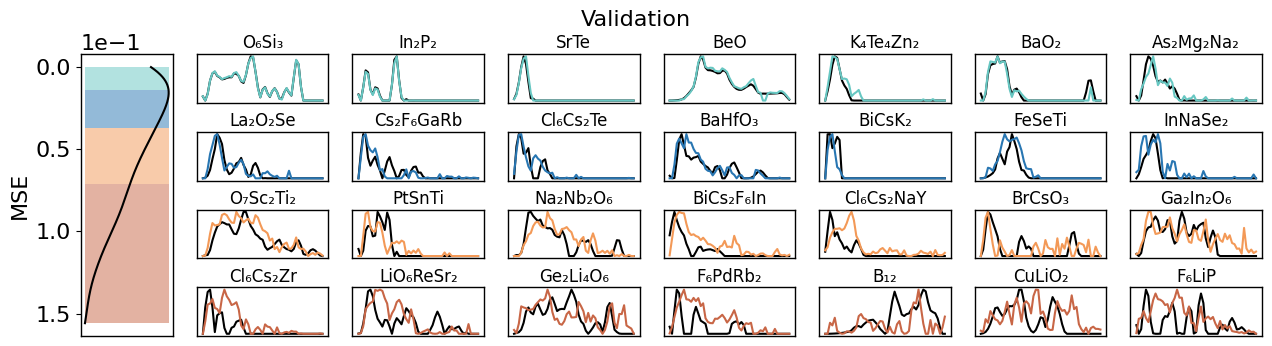

In [33]:
plot_predictions(data, idx_valid, 'Validation')

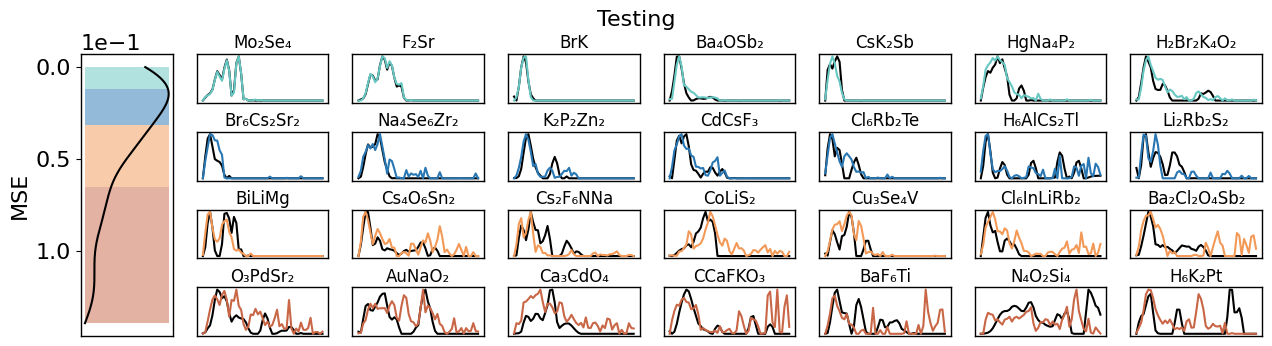

In [34]:
plot_predictions(data, idx_test, 'Testing')

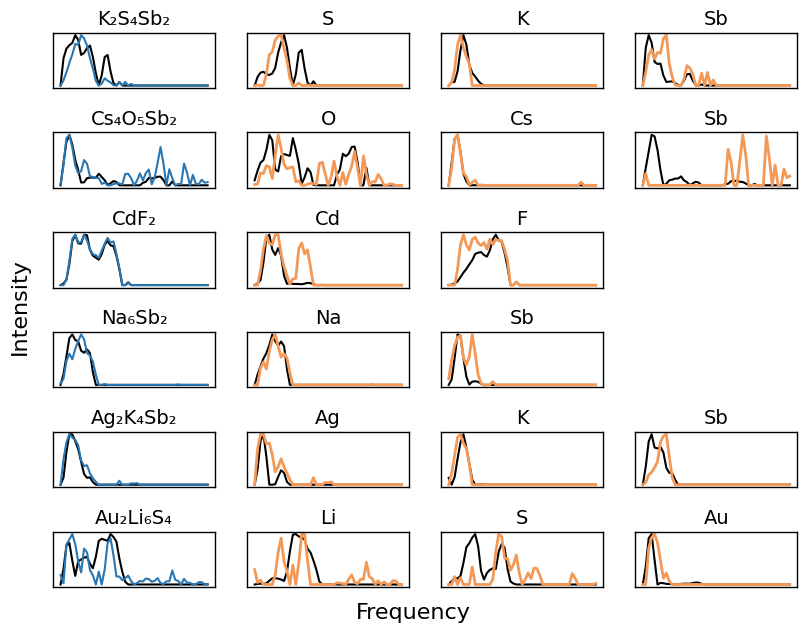

In [41]:
# compare to partial DoS
model.load_state_dict(torch.load(run_name + '.torch', map_location=device)['state'])
model.pool = False

# plot example predicted and true partial dos
plot_partials(model, data, idx_train, device=device)

## Predict on an alloy

In [42]:
df_alloy, _ = load_data('data/data_alloy.csv')
df_alloy.head()

100%|██████████| 1/1 [00:00<00:00, 11037.64it/s]


,mp_id,structure,phfreq,phdos,pdos,formula,species
0,NaN,{},"[0.0, 20.0, 40.0, 60.0, 80.0, 100.0, 120.0, 14...","[0.0, 0.37267476543017564, 0.8879380855551154,...",{},Mg3Bi1.5Sb0.5,"['Mg', 'Bi', 'Sb']"


In [43]:
# get indices of parent structures
idx_Mg3Sb2 = data.loc[data['mp_id'] == 'mp-2646'].index.to_numpy()[0]
idx_Mg3Bi2 = data.loc[data['mp_id'] == 'mp-569018'].index.to_numpy()[0]
print(f'index of Mg3Sb2: {idx_Mg3Sb2}', f'\nindex of Mg3Bi2: {idx_Mg3Bi2}')

index of Mg3Sb2: 474 
index of Mg3Bi2: 1521


In [44]:
# interpolate atomic positions and lattice constants
# 2-hot encode the atomic mass, weighted by the fraction of each species
data_alloy = []
x_Bi = np.linspace(0.01, 0.99, 99)

for i, p in tqdm(enumerate(x_Bi), total=len(x_Bi), bar_format=bar_format):
    symbols = data['data'][idx_Mg3Bi2].symbol.copy()
    positions = torch.lerp(data['data'][idx_Mg3Sb2].pos.clone(), data['data'][idx_Mg3Bi2].pos.clone(), p)
    lattice = torch.lerp(data['data'][idx_Mg3Sb2].lattice.clone(), data['data'][idx_Mg3Bi2].lattice.clone(), p)

    # edge_src and edge_dst are the indices of the central and neighboring atom, respectively
    # edge_shift indicates whether the neighbors are in different images or copies of the unit cell
    struct = data.iloc[idx_Mg3Bi2].structure.copy()
    struct.positions = positions.numpy().copy()
    struct.cell = lattice.numpy().squeeze().copy()
    edge_src, edge_dst, edge_shift = neighbor_list("ijS", a=struct, cutoff=r_max, self_interaction=True)
    
    # compute the relative distances and unit cell shifts from periodic boundaries
    edge_batch = positions.new_zeros(positions.shape[0], dtype=torch.long)[torch.from_numpy(edge_src)]
    edge_vec = (positions[torch.from_numpy(edge_dst)]
                - positions[torch.from_numpy(edge_src)]
                + torch.einsum('ni,nij->nj', torch.tensor(edge_shift, dtype=default_dtype), lattice[edge_batch]))

    # compute edge lengths (rounded only for plotting purposes)
    edge_len = np.around(edge_vec.norm(dim=1).numpy(), decimals=2)
    
    data_alloy.append(
            tg.data.Data(
            pos=positions, 
            lattice=lattice, 
            symbol=symbols,
            x=torch.lerp(data['data'][idx_Mg3Sb2].x, data['data'][idx_Mg3Bi2].x, p),
            z=torch.lerp(data['data'][idx_Mg3Sb2].z, data['data'][idx_Mg3Bi2].z, p),
            edge_index=torch.stack([torch.LongTensor(edge_src), torch.LongTensor(edge_dst)], dim=0),
            edge_shift=torch.tensor(edge_shift, dtype=default_dtype),
            edge_vec=edge_vec, edge_len=edge_len,
            phdos=data['data'][idx_Mg3Bi2].phdos.clone()
        )
    )

100%|██████████| 99/99 [00:00<00:00, 169.24it/s]


In [45]:
model.load_state_dict(torch.load(run_name + '.torch', map_location=device)['state'])
model.pool = True

dataloader = tg.loader.DataLoader([data.iloc[idx_Mg3Sb2]['data']] + data_alloy + [data.iloc[idx_Mg3Bi2]['data']],
                                  batch_size=32)

output = np.zeros((len(data_alloy) + 2, len(df_alloy['phdos'][0])))
model.to(device)
model.eval()
with torch.no_grad():
    i0 = 0
    for i, d in tqdm(enumerate(dataloader), total=len(dataloader), bar_format=bar_format):
        d.to(device)
        output[i0:i0 + len(d.phdos),:] = model(d).cpu().numpy()
        i0 += len(d.phdos)

100%|██████████| 4/4 [00:00<00:00, 58.02it/s]


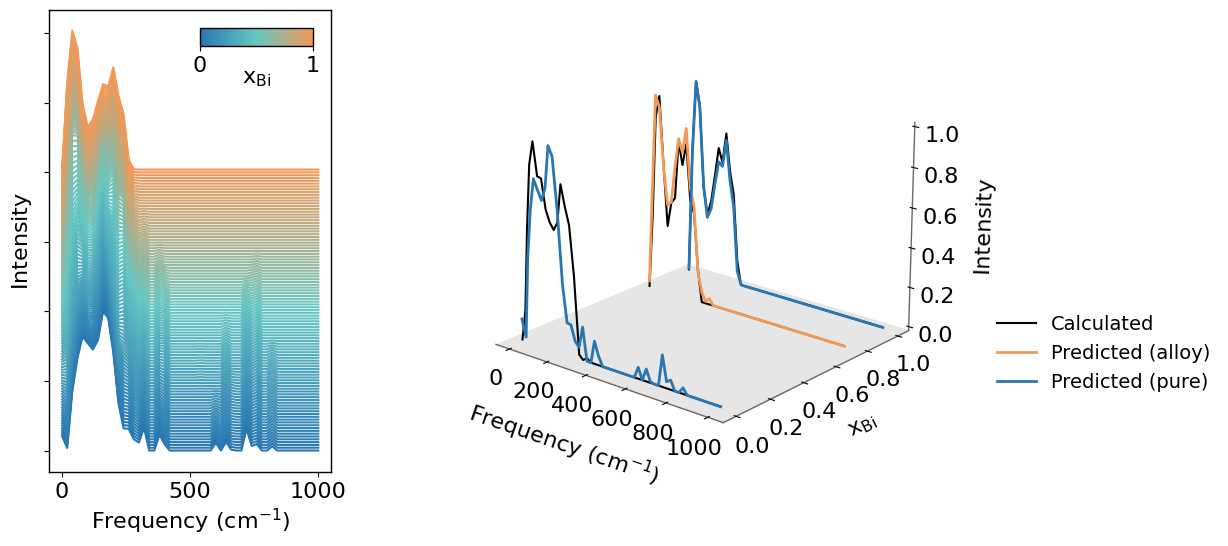

In [47]:
# plot predictions, and compare with calculated result for selected compound
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6), gridspec_kw={'width_ratios': [1,2]})
color = cmap(np.linspace(0, 1, len(output)))
f = df_alloy['phfreq'][0]

# waterfall plot of alloy predictions
s = 2./len(x_Bi)
for i in range(len(output)):
    ax1.plot(f, output[i]/output[i].max() + i*s, c=color[i])
ax1.set_yticklabels([])
ax1.set_xlabel('$Frequency\ (cm^{-1})$')
ax1.set_ylabel('$Intensity$')

sm = mpl.cm.ScalarMappable(cmap=cmap)
sm.set_array([])
cax = inset_axes(ax1, width="40%", height="4%", loc=3, bbox_to_anchor=(0.5,0.9,1,1), bbox_transform=ax1.transAxes) 
cbar = fig.colorbar(sm, cax=cax, aspect=16, orientation='horizontal', pad=-0.1)
cbar.ax.set_xlabel('$x_{Bi}$', fontsize=16, labelpad=-5)
    
# comparison to calculation
p = x_Bi.tolist().index(0.75)
ax2.remove()
ax2 = fig.add_subplot(122, projection='3d')

# plot calculations
ax2.plot(f, [0.75]*len(f), df_alloy['phdos'][0], lw=1.5, c='black', label='Calculated')
ax2.plot(f, [0]*len(f), data.iloc[idx_Mg3Sb2]['phdos'], lw=1.5, c='black')
ax2.plot(f, [1]*len(f), data.iloc[idx_Mg3Bi2]['phdos'], lw=1.5, c='black')

# plot predictions
ax2.plot(f, [0.75]*len(f), output[p]/output[p].max(), lw=2, c=palette[1], label='Predicted (alloy)')
ax2.plot(f, [0]*len(f), output[0]/output[0].max(), lw=2, c=palette[0], label='Predicted (pure)')
ax2.plot(f, [1]*len(f), output[-1]/output[-1].max(), lw=2, c=palette[0])

ax2.view_init(elev=20, azim=-50)
ax2.xaxis.set_pane_color((1., 1., 1., 1.))
ax2.yaxis.set_pane_color((1., 1., 1., 1.))
ax2.zaxis.set_pane_color((0.9, 0.9, 0.9, 1.))
ax2.grid(False)
ax2.xaxis.line.set_color('dimgray'); ax2.yaxis.line.set_color('dimgray'); ax2.zaxis.line.set_color('dimgray')
    
ax2.set_xlabel('$Frequency\ (cm^{-1})$', labelpad=14)
ax2.set_ylabel('$x_{Bi}$', labelpad=10)
ax2.set_zlabel('$Intensity$', labelpad=10)
ax2.legend(frameon=False, bbox_to_anchor=(0.9,0.4), bbox_transform=fig.transFigure);

### Open questions
- When to `pool` the model? When to not?